This notebook introduces how to use EPCOT to predict epigenomic features, CAGE-seq, chromatin contact maps, and enhancer activity, and provides examples of cross cell/tissue prediction which are presented in the paper.

If you use our codes in your research, please cite:

Zhang, Z., Qiu, Y., Feng, F., & Liu, J. (2022). A generalizable framework to comprehensively predict epigenome, chromatin organization, and transcriptome. bioRxiv. https://doi.org/10.1101/2022.05.23.493129.

Please open Google Colab notebook under GPU setting : **Runtime -> Change runtime type -> select GPU**






 **Install packages**

In [1]:
!pip install kipoiseq==0.5.2 --quiet > /dev/null
!pip install einops
!pip install gdown
# !pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 457 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Download EPCOT source code**

In [2]:
### clone our GitHub repo
!git clone https://github.com/liu-bioinfo-lab/EPCOT.git

Cloning into 'EPCOT'...
remote: Enumerating objects: 1576, done.
remote: Counting objects: 100% (356/356), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 1576 (delta 209), reused 316 (delta 183), pack-reused 1220
Receiving objects: 100% (1576/1576), 80.24 MiB | 24.38 MiB/s, done.
Resolving deltas: 100% (520/520), done.


**Import packages**

In [3]:
import kipoiseq
from kipoiseq import Interval
import pyfaidx
import pandas as pd
import numpy as np
from scipy.sparse import load_npz
import torch
import argparse
import sys,os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
sys.path.append('EPCOT/')
sys.path.append('EPCOT/GEP/')
sys.path.append('EPCOT/COP/')
from EPCOT.usage_util import *

**Download and index reference genome file**

In [4]:
### The following codes are copied from https://github.com/deepmind/deepmind-research/blob/master/enformer/enformer-usage.ipynb
fasta_file = '/root/data/genome.fa'
!mkdir -p /root/data
!wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > {fasta_file}
pyfaidx.Faidx(fasta_file)
!ls /root/data
class FastaStringExtractor:
    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}

    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream

    def close(self):
        return self.fasta.close()
fasta_extractor = FastaStringExtractor(fasta_file)

--2022-12-27 07:31:52--  http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 983659424 (938M) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>] 938.09M  20.0MB/s    in 50s     

2022-12-27 07:32:42 (18.8 MB/s) - written to stdout [983659424/983659424]

genome.fa  genome.fa.fai


**Download example input DNase-seq profiles and EPCOT trained models**


[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.7485616.svg)](https://doi.org/10.5281/zenodo.7485616)

In [5]:
# download models trained on DNase-seq or ATAC-seq
!wget -O models.zip https://zenodo.org/record/7485616/files/models.zip?download=1
!unzip models.zip
# download processed DNase-seq or ATAC-seq
!wget -O DNAaccessibility.zip https://zenodo.org/record/7485616/files/DNAaccessibility.zip?download=1
!unzip DNAaccessibility.zip

--2022-12-27 07:33:26--  https://zenodo.org/record/7485616/files/models.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1535220786 (1.4G) [application/octet-stream]
Saving to: ‘models.zip’

models.zip          100%[===================>]   1.43G  12.3MB/s    in 2m 59s  

2022-12-27 07:36:27 (8.18 MB/s) - ‘models.zip’ saved [1535220786/1535220786]

Archive:  models.zip
   creating: models/
  inflating: __MACOSX/._models       
  inflating: models/GM12878_CTCF_chiapet.pt  
  inflating: __MACOSX/models/._GM12878_CTCF_chiapet.pt  
  inflating: models/hic_HFF_atac.pt  
  inflating: __MACOSX/models/._hic_HFF_atac.pt  
  inflating: models/.DS_Store        
  inflating: __MACOSX/models/._.DS_Store  
  inflating: models/HFF_MicroC_atac.pt  
  inflating: __MACOSX/models/._HFF_MicroC_atac.pt  
  inflating: models/hic_GM12878_transformer.pt  
  inflating:

In [6]:
# import gdown
# gdown.download_folder('https://drive.google.com/drive/u/1/folders/1REE056hPXSTOt2nK6B6bpkwnnofAUdsE')
# gdown.download_folder('https://drive.google.com/drive/u/1/folders/1OatqvhcWrKwLBH5CNDCO7DPDmeGr7lL4')

**Specify device**

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## **Epigenomic feature, gene expression, and contact map prediction using EPCOT**

This section demonstrates how to use EPCOT to predict multiple modalities, including
* task1: Epigenomic feature prediction (EFP)
* task2: CAGE-seq gene expression prediction (GEP)
* task3: 5kb-resolution Hi-C (ChIA-PET) contact map prediction (COP)
* task4: 1kb-resolution Micro-C contact map prediction

**Steps:**
1. **Load input DNase-seq**. The inputs to EPCOT are RPGC normalized DNase-seq or ATAC-seq. For how to generate the input DNase-seq, please see [our GitHub repo](https://github.com/liu-bioinfo-lab/EPCOT/tree/main/Data). Then you can use a function ```load_input_dnase``` to load DNase-seq.

2. **Load trained models**. We have four functions to load trained models of each task (```load_pre_training_model```, ```load_cage_model```,```load_hic_model```,```load_microc_model```), you need to specify the save paths to each of EPCOT models. 

3. **Specify input arguments of each prediction function**. Functions ```predict_epis```, ```predict_cage```, ```predict_hic```, and ```predict_microc``` predict epigenomic features, CAGE-seq, Hi-C (ChIA-PET), and Micro-C, respectively, which have following arguments:
   * ```model``` specifies the model to predict each of the modalities
   * ```chrom```, ```start```, ```end```  sepecify chromosome, start position, end position of the input genomic region
   * ```dnase``` : DNase-seq of cell/tissue type of interest. You can input your own DNase-seq  to make predictions.


4. **Make predictions and visualize prediction results**.

Modalities can also be predicted on ATAC-seq by using models trained on ATAC-seq

**Flow chart:**

<img align="left" width="750" height="450" 
 src='https://drive.google.com/uc?export=view&id=1AJaPBPgMofcGvB_oVmMdeES3D07lj-Gg'/>




Please see below for how to predict each of the tasks in GM12878 cell line

**Load input DNase-seq of GM12878**

In [8]:
### input_dnase_file='PATH/TO/INPUT/DNase-seq/FILE'
input_dnase_file='DNAaccessibility/GM12878_dnase.pickle'
GM12878_dnase=load_input_dnase(input_dnase_file)

**Task1: Epigenomic feature prediction (EFP)**

load pre-training model

In [9]:
### saved_model='PATH/TO/SAVED/PRE-TRAINING/MODEL'
saved_model='models/pretrain_dnase.pt'
pretrain_model=load_pre_training_model(saved_model,device)

 specify a region of interest and predict epigenomic features on the region

In [10]:
### specify the coordinates of a genomic region ('end-start' should be divisble by 1000)
chrom,start,end=['chr11',46750000,47750000]
pred_score_epi=predict_epis(model=pretrain_model,
                            chrom=chrom, start=start,end=end,
                            dnase=GM12878_dnase,
                            fasta_extractor=fasta_extractor)
pred_score_epi.shape

(1000, 245)

In [11]:
### view the list of epigenomic features predicted by EPCOT
with open('EPCOT/Data/epigenomes.txt', 'r') as f:
    epigenomes = f.read().splitlines()
!head -3 EPCOT/Data/epigenomes.txt

CTCF
RAD21
ATF7


Visualize results

Text(0.5, 0, 'chrchr11:46750000-47750000')

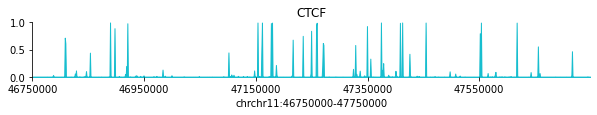

In [12]:
### specify an epigenomic feature whose predicted binding activities are to be visualized  (select the epigenomic feature from the list of predicted epigenomic features https://github.com/liu-bioinfo-lab/EPCOT/blob/main/Profiles/epigenomes.txt)
interested_epi='CTCF'

### plot results
epi_idx=search_tf(interested_epi)
fig,ax=plt.subplots(figsize=(10,1))
val=pred_score_epi[:,epi_idx]
plot_bindings(ax,val, chrom,start,end)
ax.set_title(epigenomes[epi_idx])
ax.set_xlabel('chr%s:%s-%s'%(chrom,start,end))

**Task 1.1: Epigenomic feature signal prediction**
* The downstream model to predict 1kb-resolution epigenomic feature signals (arcsinh-transformed) takes the input of 500kb genomic regions and predicts the signals in the centered 400kb region.

In [13]:
### saved_model='PATH/TO/SAVED/CAGE-seq/DOWNSTREAM/MODEL'
saved_model='models/dnase_epi_track.pt'
track_model=load_epi_track_model(saved_model,device)

In [14]:
### specify a 400kb input genomic region  ('hic_end-hic_start' should be equal 400000)
chrom,start,end=['chr11',46750000,47150000]
pred_track=predict_track(
    model=track_model,
    chrom=chrom,start=start,end=end,
    dnase=GM12878_dnase,
    fasta_extractor=fasta_extractor)

Text(0.5, 0, 'chrchr11:46750000-47150000')

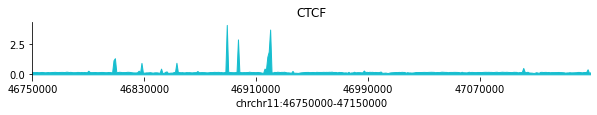

In [15]:
interested_epi='CTCF'
### plot results
epi_idx=search_tf(interested_epi)
fig,ax=plt.subplots(figsize=(10,1))
val=pred_track[:,epi_idx]
plot_cage(ax,val, chrom,start,end)
ax.set_title(epigenomes[epi_idx])
ax.set_xlabel('chr%s:%s-%s'%(chrom,start,end))

**Task2: CAGE-seq gene expression prediction (GEP)**
* The downstream model to predict 1kb-resolution CAGE-seq takes the input of 250kb genomic regions and predicts the CAGE-seq in the centered 200kb region.

load CAGE-seq downstream model

In [16]:
### saved_model='PATH/TO/SAVED/CAGE-seq/DOWNSTREAM/MODEL'
saved_model='models/cage_transformer.pt'
cage_model=load_cage_model(saved_model,device)

 specify a region of interest and predict 1kb-resolution CAGE-seq on the region

In [17]:
### specify a genomic region ('cage_end-cage_start' should be divisible by 200000)
cage_chrom,cage_start,cage_end=['chr11',46750000,47750000]
pred_cage=predict_cage(model=cage_model,
                       chrom=cage_chrom,start=cage_start,end=cage_end,
                       dnase=GM12878_dnase,
                       fasta_extractor=fasta_extractor,
                       )

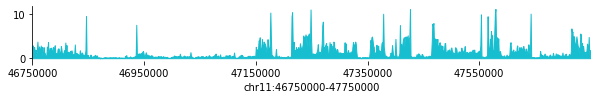

In [18]:
### plot results
fig,ax=plt.subplots(figsize=(10,1))
plot_cage(ax,pred_cage,cage_chrom,cage_start,cage_end)

**Task3: Hi-C and ChIA-PET contact map prediction (COP)**
* The downstream model in these two tasks has the same model archietcture.
* EPCOT predicts the upper triangular of contact matrices in the centered 960kb region of the input 1Mb region

load Hi-C downstream model trained on GM12878

In [20]:
### saved_model='PATH/TO/SAVED/Hi-C/DOWNSTREAM/MODEL'
saved_model='models/hic_GM12878_transformer.pt'

hic_model=load_hic_model(saved_model,device)

In [21]:
### specify a 1Mb input genomic region  ('hic_end-hic_start' should be equal 1000000)
hic_chrom,hic_start,hic_end=['chr11',46750000,47750000]

### output a 192x192 contact matrices of the centered 960kb region
pred_hic=predict_hic(
    model=hic_model,
    chrom=hic_chrom,start=hic_start,end=hic_end,
    dnase=GM12878_dnase,
    fasta_extractor=fasta_extractor)

Text(0.5, 0, 'chr11:46770000-47730000')

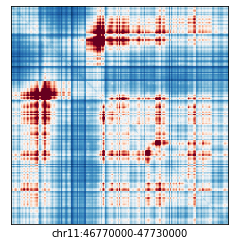

In [22]:
### plot results
fig,ax=plt.subplots()
plot_hic(ax,pred_hic,vmin=0,vmax=5)
ax.set_xlabel('%s:%s-%s'%(hic_chrom,hic_start+20000,hic_end-20000))

load CTCF ChIA-PET downstream model trained on GM12878

In [23]:
### save_model='PATH/TO/SAVED/CTCF/ChIA-PET/DOWNSTREAM/MODEL'
saved_model='models/GM12878_CTCF_chiapet.pt'

chiapet_model=load_hic_model(saved_model,device)

In [24]:
### please input a 1Mb region (end-start=1000000)
hic_chrom,hic_start,hic_end=['chr11',74750000,75750000]

pred_hic=predict_hic(
    model=chiapet_model,
    chrom=hic_chrom,start=hic_start,end=hic_end,
    dnase=GM12878_dnase,
    fasta_extractor=fasta_extractor)
pred_hic.shape

(192, 192)

Text(0.5, 0, 'chr11:74770000-75730000')

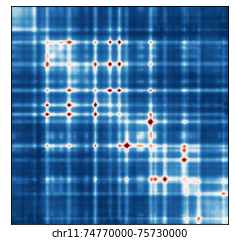

In [25]:
### plot results
fig,ax=plt.subplots()
plot_hic(ax,pred_hic,vmin=0,vmax=3)
ax.set_xlabel('%s:%s-%s'%(hic_chrom,hic_start+20000,hic_end-20000))

**Task4: Micro-C contact map prediction**
* EPCOT predicts the upper triangular of 1kb-reolsution Micro-C contact matrices in the centered 500kb region of the input 600kb region

load HFF DNase-seq

In [26]:
HFF_dnase=load_input_dnase('DNAaccessibility/HFFc6_dnase.pickle')

Load Micro-C downstream model trained on HFF

In [27]:
saved_model='models/HFF_Micro-C_transformer.pt'
microc_model=load_microc_model(saved_model,device)

In [28]:
### specify a 600kb input genomic region (end-start=600000)
microc_chrom,microc_start,microc_end=['chr11',113000000,113600000]
pred_microc=predict_microc(model=microc_model,
                           chrom=microc_chrom,start=microc_start,end=microc_end,
                           dnase=HFF_dnase,
                           fasta_extractor=fasta_extractor)

Text(0.5, 0, 'chr11:113050000-113550000')

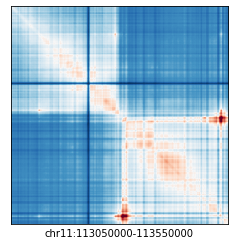

In [29]:
### plot results
fig,ax=plt.subplots()
plot_hic(ax,pred_microc,vmin=-2,vmax=2)
ax.set_xlabel('%s:%s-%s'%(microc_chrom,microc_start+50000,microc_end-50000))

## Examples of cross-cell/tissue type prediction
This section provides some detailed examples of predicting modalities in new cell/tissue types, which are presented in the paper, including 

* Cross-cell type prediction in HUVEC and HCT116

* Cross-tissue type prediction in GTEx tissue dononrs

* Cross-cell type ChIA-PET prediction 

* Cross-cell/tissue type Micro-C prediction 

In cross-cell type CAGE-seq and COP prediction, we use batch statistics in BatchNorm instead of running statistics, here BatchNorm works similar to InstanceNorm.

**Example 1: cross-cell type prediction in HUVEC**

<!-- For cross-cell type prediction, it is important that the normalized DNase-seq in training cell types and testing cell types have similar data scales, if not, maybe some normalization methods are needed. -->

Load HUVEC DNase-seq

In [30]:
input_dnase_file='DNAaccessibility/HUVEC_dnase.pickle'

HUVEC_dnase=load_input_dnase(input_dnase_file)

In [31]:
saved_model='models/pretrain_dnase.pt'
pretrain_model=load_pre_training_model(saved_model,device)

saved_model='models/cage_transformer.pt'
cage_model=load_cage_model(saved_model,device)

###  Hi-C cross-cell type predicition
###  load models trained on GM12878 and HFF
saved_model='models/hic_GM12878_transformer.pt'
hic_model_gm=load_hic_model(saved_model,device)

saved_model='models/hic_HFF_transformer.pt'
hic_model_hff=load_hic_model(saved_model,device)

In [32]:
###  cross-cell type epigenomic feature prediction
chrom,start,end=['chr11',86770000,87730000]
pred_epi= predict_epis(model=pretrain_model,
                       chrom=chrom,start=start,end=end,
                       dnase=HUVEC_dnase,
                       fasta_extractor=fasta_extractor)

###  Cross-cell type CAGE-seq prediction
cage_chrom,cage_start,cage_end=['chr11',86750000,87750000]
pred_cage= predict_cage(model=cage_model,
                        chrom=cage_chrom,start=cage_start,end=cage_end,
                        dnase=HUVEC_dnase,
                        fasta_extractor=fasta_extractor,
                        cross_cell_type=True)

###  cross-cell type contact map prediction 
hic_chrom,hic_start,hic_end=['chr11',86750000,87750000]
pred_hic1=predict_hic(model=hic_model_gm,
                      chrom=hic_chrom,start=hic_start,end=hic_end,
                      dnase=HUVEC_dnase,
                      fasta_extractor=fasta_extractor,
                      cross_cell_type=True
                      )
pred_hic2=predict_hic(hic_model_hff,hic_chrom,hic_start,hic_end,HUVEC_dnase,fasta_extractor,cross_cell_type=True)

### using ensemble of models trained on GM12878 and HFF
pred_hic=(pred_hic1+pred_hic2)/2

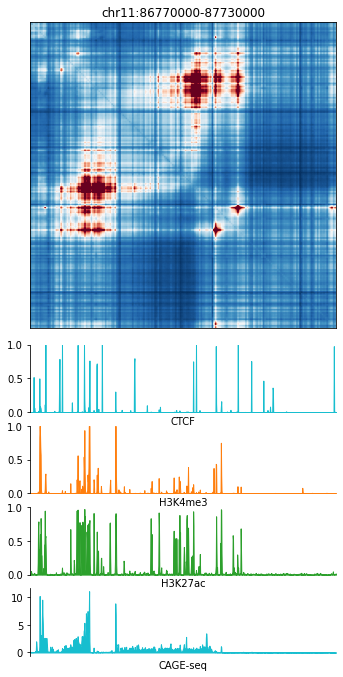

In [33]:
###  plot results
fig = plt.figure(figsize=(5, 9.5))
gs = GridSpec(8, 5, wspace = 0.75, hspace = 0.2, left = 0.05, top = 0.98, right = 0.9, bottom = 0.05)
ax_hic = fig.add_subplot(gs[:4, :5])
ax_track= [fig.add_subplot(gs[4+i:5+i,:5]) for i in range(4)]
plot_hic(ax_hic,pred_hic,vmin=0,vmax=5)
epis=['CTCF','H3K4me3','H3K27ac','CAGE-seq']
plot_bindings(ax_track[0],pred_epi[:,0], chrom,start,end)
plot_bindings(ax_track[1],pred_epi[:,-3], chrom,start,end,color='tab:orange')
plot_bindings(ax_track[2],pred_epi[:,-6], chrom,start,end,color='tab:green')
plot_cage(ax_track[3],pred_cage[20:-20],cage_chrom,cage_start,cage_end)
for i in range(len(ax_track)):
  ax_track[i].set_xticks([])
  ax_track[i].set_xlabel(epis[i])
ax_hic.set_title('%s:%s-%s'%(chrom,start,end))
plt.show()

**Example 2: cross-tissue type prediction in GTEx tissue donors**

load DNase-seq of stomach tisssue (female 53)

In [34]:
input_dnase_file='DNAaccessibility/stomach_f53_dnase.pickle'

stomach_dnase=load_input_dnase(input_dnase_file)

Cross-tissue type contact map prediction here uses model trained on transverse colon (male 37 years) whose contact map is smoothed. You can also use models trained on ENCODE cell lines whose contact maps are not smoothed.

In [35]:
### cross-tissue type epigenomic feature prediction
saved_model='models/pretrain_dnase.pt'
pretrain_model=load_pre_training_model(saved_model,device)

### cross-tissue type contact map prediction using model trained on transverse colon (male 37 years)
saved_model='models/hic_trans_colon_m37_transformer.pt'
# saved_model='models/hic_GM12878_transformer.pt'
hic_model=load_hic_model(saved_model,device)

In [36]:
chrom,start,end=['chr11',7750000,8750000]

pred_hic=predict_hic(hic_model,chrom,start,end,stomach_dnase,fasta_extractor,cross_cell_type=True)
pred_epi= predict_epis(pretrain_model,chrom,start+20000,end-20000,stomach_dnase,fasta_extractor)

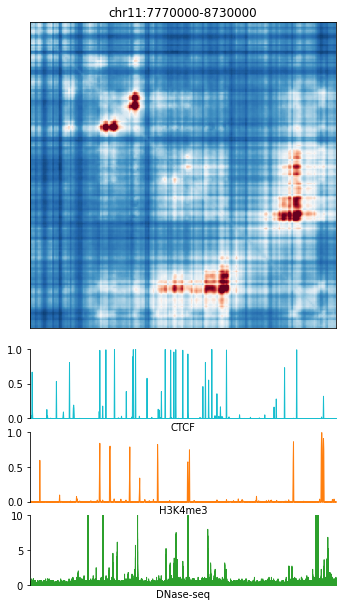

In [37]:
# plot results
fig = plt.figure(figsize=(5, 8.5))
gs = GridSpec(7, 5, wspace = 0.75, hspace = 0.2, left = 0.05, top = 0.98, right = 0.9, bottom = 0.05)
ax_hic = fig.add_subplot(gs[:4, :5])
ax_track= [fig.add_subplot(gs[4+i:5+i,:5]) for i in range(3)]
plot_hic(ax_hic,pred_hic,vmin=0,vmax=4)
epis=['CTCF','H3K4me3','DNase-seq']
plot_bindings(ax_track[0],pred_epi[:,0], chrom,start,end)
plot_bindings(ax_track[1],pred_epi[:,-3], chrom,start,end,color='tab:orange')
plot_cage(ax_track[2],stomach_dnase[int(chrom[3:])].toarray().squeeze()[start:end],chrom,start,end,color='tab:green')
ax_track[2].set_ylim(0,10)
for i in range(len(ax_track)):
  ax_track[i].set_xticks([])
  ax_track[i].set_xlabel(epis[i])
ax_hic.set_title('%s:%s-%s'%(chrom,start+20000,end-20000))
plt.show()

**Example 3: cross-cell type ChIA-pet prediction**

load HFF DNase-seq

In [38]:
HFF_dnase=load_input_dnase('DNAaccessibility/HFFc6_dnase.pickle')

In [39]:
saved_model='models/GM12878_CTCF_chiapet.pt'
chiapet_model=load_hic_model(saved_model,device)

The model trained on GM12878 is transferred to HFF cell line

In [40]:
hic_chrom,hic_start,hic_end=['chr11',74750000,75750000]

pred_chiapet=predict_hic(chiapet_model,hic_chrom,hic_start,hic_end,HFF_dnase,fasta_extractor,cross_cell_type=True)

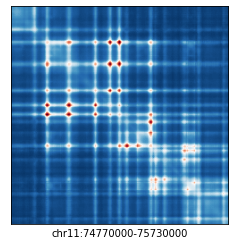

In [41]:
### plot results
fig,ax=plt.subplots()
plot_hic(ax,pred_chiapet,vmin=0,vmax=3)
ax.set_xlabel('%s:%s-%s'%(hic_chrom,hic_start+20000,hic_end-20000))
plt.show()

**Example 4: Cross-cell/tissue type Micro-C contact map prediction**

In [42]:
stomach_dnase=load_input_dnase('DNAaccessibility/stomach_f53_dnase.pickle')
tbn_dnase=load_input_dnase('DNAaccessibility/tibial_nerve_m37_dnase.pickle')
K562_dnase=load_input_dnase('DNAaccessibility/K562_dnase.pickle')
GM12878_dnase=load_input_dnase('DNAaccessibility/GM12878_dnase.pickle')
HUVEC_dnase=load_input_dnase('DNAaccessibility/HUVEC_dnase.pickle')
A549_dnase=load_input_dnase('DNAaccessibility/A549_dnase.pickle')

In [44]:
saved_model='models/HFF_Micro-C_transformer.pt'
microc_model=load_microc_model(saved_model,device)

In [45]:
# microc_chrom,microc_start,microc_end=['chr11',113000000,113600000]
microc_chrom,microc_start,microc_end=['chr11',67000000,67600000]

pred_microc_huvec=predict_microc(model=microc_model,
                           chrom=microc_chrom,start=microc_start,end=microc_end,
                           dnase=HUVEC_dnase,
                           fasta_extractor=fasta_extractor,
                           cross_cell_type=True)

pred_microc_gm12878=predict_microc(microc_model,microc_chrom,microc_start,microc_end,GM12878_dnase,fasta_extractor,cross_cell_type=True)

pred_microc_a549=predict_microc(microc_model,microc_chrom,microc_start,microc_end,A549_dnase,fasta_extractor,cross_cell_type=True)

pred_microc_stomach=predict_microc(microc_model,microc_chrom,microc_start,microc_end,stomach_dnase,fasta_extractor,cross_cell_type=True)

pred_microc_tbn=predict_microc(microc_model,microc_chrom,microc_start,microc_end,tbn_dnase,fasta_extractor,cross_cell_type=True)

pred_microc_k562=predict_microc(microc_model,microc_chrom,microc_start,microc_end,K562_dnase,fasta_extractor,cross_cell_type=True)

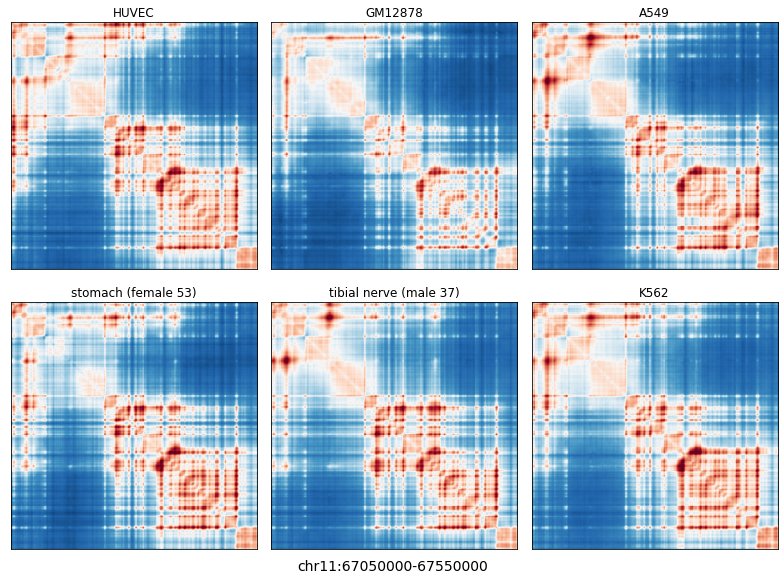

In [46]:
cells=['HUVEC','GM12878','A549','stomach (female 53)', 'tibial nerve (male 37)','K562']
fig,axs=plt.subplots(2,3,figsize=(11,8))
microc_mat=[pred_microc_huvec,pred_microc_gm12878,pred_microc_a549,pred_microc_stomach,pred_microc_tbn,pred_microc_k562]
for i in range(2):
    for j in range(3):
        plot_hic(axs[i,j],microc_mat[i*3+j],vmin=-2,vmax=2)
        axs[i,j].set_title(cells[i*3+j])
fig.text(0.5,0,'%s:%s-%s'%(microc_chrom,microc_start+50000,microc_end-50000),fontsize=14,ha='center')
plt.tight_layout()
plt.show()

## Investigating TF impacts to enhancer activity
The section demonstrates how to analyze contributions of TFs to enhancer activity prediction. An example in A549 cell line is provided.

You can replace the input DNase-seq file and labels of enhancers with your own data to perform analysis.

In [47]:
### load A549 DNase-seq 
A549_dnase=load_input_dnase('DNAaccessibility/A549_dnase.pickle')

### positive and negative samples in A549
pos_enh=np.genfromtxt('EPCOT/EAP/data/A549_positive.bed',dtype='int')
neg_enh=np.genfromtxt('EPCOT/EAP/data/A549_negative.bed',dtype='int')

In [48]:
### view the label file of active enhancers
!head -3 'EPCOT/EAP/data/A549_positive.bed'

1	779000	780000
1	943000	944000
1	1013000	1014000


In [49]:
### load pre-training model
saved_model='models/pretrain_dnase.pt'
pretrain_model=load_pre_training_model(saved_model,device)

In [50]:
### select 50 positives and 50 negatives to run an example experiment
samples_pos=pos_enh[:50]
samples_neg=neg_enh[:50]
labels=np.concatenate((np.ones(samples_pos.shape[0]),np.zeros(samples_neg.shape[0])))
samples=np.vstack((samples_pos,samples_neg))

In [51]:
### prepare inputs to the pre-training model
inputs=[]
for i in range(samples.shape[0]):
    chrom,start,end=samples[i]
    input=generate_input(fasta_extractor,'chr'+str(chrom),start,end,A549_dnase[str(chrom)].toarray().squeeze())
    inputs.append(input)
inputs=np.vstack(inputs)
inputs.shape

(100, 5, 1600)

In [52]:
### predict epigenomic features 
pred_epis=[]
batch_size=24
for i in np.arange(0,inputs.shape[0],batch_size):
    x=torch.tensor(inputs[i:i+batch_size]).float().to(device)
    with torch.no_grad():
        output=pretrain_model(x)
        pred_epis.append(output.cpu().detach().numpy())
pred_epis=np.vstack(pred_epis)
pred_epis.shape

(100, 245)

Running logistic regression (LR) to investigate the contributions of 236 TFs to enhancer activity prediction, the inputs to the LR model are predicted scores of 236 TFs.

In [53]:
from sklearn.linear_model import LogisticRegression
pred_tfs=pred_epis[:,:236]
clf = LogisticRegression(random_state=0,penalty='l1',solver='saga',C=0.2,max_iter=10000).fit(pred_tfs, labels)
### weights in logistic regression
clf.coef_

array([[ 0.        ,  0.        ,  0.        ,  0.0670251 ,  0.        ,
        -0.01473167,  0.        ,  0.        ,  0.24710129,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.03936494,  0.        ,  0.        ,  0.        ,
         0.03612107,  0.        ,  0.        , -0.18938643,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.15718545,  0.        ,  0.        ,  0.        ,
         0.04723629,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -0.23980069,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 